In [1]:
import numpy as np
import pylab as plt

import torch
import torch.nn
import torch.optim
import torch.utils.data
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder

In [2]:
class MNISTdataset(torch.utils.data.Dataset):

    def __init__(self):

        d0 = np.fromfile('mnist-data/data0', dtype=np.uint8).reshape((1000, 28, 28))
        d1 = np.fromfile('mnist-data/data1', dtype=np.uint8).reshape((1000, 28, 28))
        d2 = np.fromfile('mnist-data/data2', dtype=np.uint8).reshape((1000, 28, 28))
        d3 = np.fromfile('mnist-data/data3', dtype=np.uint8).reshape((1000, 28, 28))
        d4 = np.fromfile('mnist-data/data4', dtype=np.uint8).reshape((1000, 28, 28))
        d5 = np.fromfile('mnist-data/data5', dtype=np.uint8).reshape((1000, 28, 28))
        d6 = np.fromfile('mnist-data/data6', dtype=np.uint8).reshape((1000, 28, 28))
        d7 = np.fromfile('mnist-data/data7', dtype=np.uint8).reshape((1000, 28, 28))
        d8 = np.fromfile('mnist-data/data8', dtype=np.uint8).reshape((1000, 28, 28))
        d9 = np.fromfile('mnist-data/data9', dtype=np.uint8).reshape((1000, 28, 28))
        dataX = np.concatenate((d0, d1, d2, d3, d4, d5, d6, d7, d8, d9))
        dataY = np.concatenate(([0]*1000, [1]*1000, [2]*1000, [3]*1000, [4]*1000, [5]*1000, [6]*1000, [7]*1000, [8]*1000, [9]*1000))
        indices = np.random.permutation(10000)
        dataX = dataX[indices]
        dataY = dataY[indices]
        dataX = dataX[:600]
        dataY = dataY[:600]
        self.dataX = dataX.reshape(600, 784).astype(np.float32) / 255
        self.dataY = dataY
#         self.dataY = OneHotEncoder(categories='auto', sparse=False).fit_transform(dataY.reshape(-1, 1))

    def __len__(self):
        return self.dataX.shape[0]

    def __getitem__(self, i):
        img = torch.Tensor(self.dataX[i].reshape(1,28,28))
        num = self.dataY[i]
        return (img, num)

In [3]:
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.c1 = torch.nn.Conv2d(1, 8, (3,3), padding=1, bias=False)
        self.c2 = torch.nn.Conv2d(8, 8, (3,3), padding=1, bias=False)
        self.d1 = torch.nn.Linear(8*28*28, 512)
        self.d2 = torch.nn.Linear(512, 512)
        self.d3 = torch.nn.Linear(512, 10)
        
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = x.view(-1, 28*28*8)
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        x = F.softmax(self.d3(x))
        return x

In [4]:
model = Net().cuda()

dataset = MNISTdataset()
traingenerator = torch.utils.data.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.0)

/usr/local/lib/python3.7/dist-packages/torch/cuda/__init__.py:132: UserWarning: 
    Found GPU0 GeForce GTX 660 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [7]:
losses = np.zeros(4)
for i in tqdm(range(4)):
    for batch in traingenerator:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs.cuda().float())
        loss = criterion(outputs, labels.cuda().long())
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        for batch in traingenerator:
            inputs, labels = batch
            outputs = model(inputs.cuda().float())
            loss = criterion(outputs, labels.cuda().long())
            losses[i] += loss.item()

  0%|          | 0/4 [00:00<?, ?it/s]


RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR

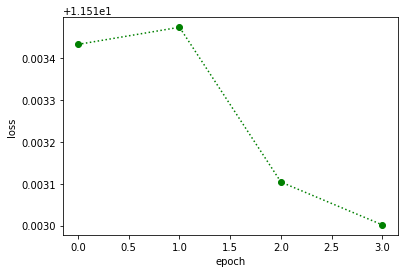

In [9]:
plt.plot(losses, 'go:')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.show()

In [10]:
dataset = MNISTdataset()
yt = dataset.dataY
yp = np.zeros(yt.shape[0])
for i in tqdm(range(yp.shape[0])):
    x = torch.tensor(dataset.dataX[i].reshape(1,1,28,28))
    y = model(x)
    yp[i] = y.detach().numpy().argmax(axis=1)
# yp = ypp.argmax(axis=0)
print(classification_report(yt, yp))

100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 347.83it/s]
c:\users\u0001\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        71
           1       0.00      0.00      0.00        52
           2       0.00      0.00      0.00        49
           3       0.00      0.00      0.00        55
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00        74
           6       0.10      0.12      0.11        64
           7       0.00      0.00      0.00        62
           8       0.09      0.90      0.16        51
           9       0.00      0.00      0.00        62

    accuracy                           0.09       600
   macro avg       0.02      0.10      0.03       600
weighted avg       0.02      0.09      0.03       600

